# Westeros Tutorial Part 1.X - Building the Westeros Baseline using xlsx input data

## Scope of this tutorial: Building a Simple Energy Model using xlsx data

This tutorial explains how the Westeros Baseline scenario can be built using data retrieved from xlsx files.

The tutorial is split into two parts.

The first part will create a scenario and basic parameters will be added including the modeling time-horizon, the discount rate. This code is a repetition of that used in the tutorial XXXXX

The sceond part will then import various xlsx files to add technologies, demands and constraints to the model.

## Online documentation

The full framework documentation is available at [https://docs.messageix.org](https://docs.messageix.org)

## Step 1. Setting up the scenario

## Ready, steady, go!

First, we import all the packages we need. We import a utility function called *make_df*, which can be used to wrap the input data into dataframes that can be saved in model parameters.

In [1]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
mp = ixmp.Platform()

In [16]:
scenario = message_ix.Scenario(mp, model='Westeros Electrified', 
                               scenario='baseline_xlsx', version='new')

## Model Structure

We start by defining basic characteristics of the model, including time, space, and the energy system structure.

In [17]:
history = [690]
model_horizon = [700, 710, 720]
scenario.add_horizon(
    year=history + model_horizon,
    firstmodelyear=model_horizon[0]
)

In [18]:
country = 'Westeros'
scenario.add_spatial_sets({'country': country})

In [19]:
scenario.add_set("commodity", ["electricity", "light"])
scenario.add_set("level", ["secondary", "final", "useful"])
#scenario.add_set("technology", ['coal_ppl', 'wind_ppl', 'grid', 'bulb'])
#scenario.add_set("mode", "standard")

In [20]:
scenario.add_par("interestrate", model_horizon, value=0.05, unit='-')

### Important: Note that the data has not yet been commited. This is because at a minimum, the set technology needs to be defined otherwise an error message will be raised when commiting the scenario. Hence, we will continue in this tutorial adding data, step-by-step, making a single commit priior to solving.

## Supply and Demand (or Balancing Commodities)

Instead of using the add_par for adding data to a MESSAGEix parameter, we will import data from a xlsx file. Because the scenario has not been commited, data is also imported without commiting individual steps.

In [21]:
scenario.read_excel("westeroes_baseline_demand.xlsx", add_units=True, commit_steps=False)

Open the above indicated xlsx file and browse its contents. You will find that it includes two sheets. A sheet `demand` which contains the based on the index structure of the parameters `demand`

In [22]:
print(scenario.idx_names('demand'))

['node', 'commodity', 'level', 'year', 'time']


In addition, numerical values have been added under the index-name `value` and the units have been specified under the index-name 'unit'

### Adding technologies
The following sheets are distinguished in the data input file. The naming convention is analogue to the set or parameter to which the data contained within refers to. The exception is the last sheet, which is used by the importer data is used to populate sets or parameters. This is important as first sets will need to be populated, to allow the import of parameters.
a. `mode`
b. `technology`
c. `capacity_factor`
d. `input`
e. `output`
f. `technical_lifetime`
g. `ix_type_mapping`

In [23]:
scenario.read_excel("westeroes_baseline_technology_basic.xlsx", add_units=True, commit_steps=False)

## Technological Diffusion and Contraction

In [24]:
scenario.read_excel("westeroes_baseline_technology_constraint.xlsx", add_units=True, commit_steps=False)

## Defining an Energy Mix (Model Calibration)

In [25]:
scenario.read_excel("westeroes_baseline_technology_historic.xlsx", add_units=True, commit_steps=False)

### Investment, Fixed O&M and Varaible O&M Costs

In [26]:
scenario.read_excel("westeroes_baseline_technology_economic.xlsx", add_units=True, commit_steps=False)

## Time to Solve the Model

First, we *commit* the model structure and input data (sets and parameters).
In the `ixmp` backend, this creates a new model version in the database, which is assigned a version number automatically:

In [28]:
scenario.set_as_default()

In [29]:
scenario.solve()

In [30]:
scenario.var('OBJ')['lvl']

369297.75

## Plotting Results

Analyzing the results of a scenario after it is solved is called **reporting**.
MESSAGE*ix* includes flexible and customizable message_ix/tutorial for reporting, but here we wish to focus on the results of our example scenario.
We use some custom code to set up some simple plots:

In [31]:
# Create a Reporter object to describe and carry out reporting
# calculations and operations (like plotting) based on `scenario`
from message_ix.reporting import Reporter

rep = Reporter.from_scenario(scenario)

# Add keys like "plot activity" to describe reporting operations.
# See tutorial/utils/plotting.py
from message_ix.util.tutorial import prepare_plots

prepare_plots(rep)

Now the object `rep` is ready to generate several plots.

(For a detailed introduction to how the `Reporter` works, see `westeros_report.ipynb`.)

### Activity

How much energy is generated in each time period from the different potential sources?

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

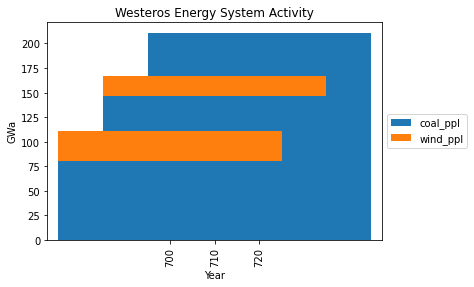

In [32]:
# Only show a subset of technologies in the follow plots;
# e.g. exclude "bulb" and "grid"
rep.set_filters(t=["coal_ppl", "wind_ppl"])

# Trigger the calculation and plotting
rep.get("plot activity")

### Capacity

How much capacity of each plant is installed in each period?

<AxesSubplot:title={'center':'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

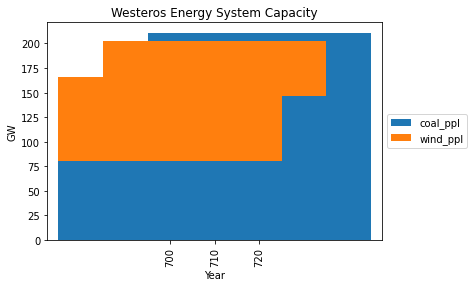

In [33]:
# Create a different plot. The same filters are still active.
rep.get("plot capacity")

### Electricity Price

And how much does the electricity cost? These prices are in fact **shadow prices** taken from the **dual variables** of the model solution.
They reflect the marginal cost of electricity generation (i.e., the additional cost of the system for supplying one more unit of
electricity), which is in fact the marginal cost of the most expensive operating generator.  

Note the price drop when the most expensive technology is no longer in the system.

<AxesSubplot:title={'center':'Westeros Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

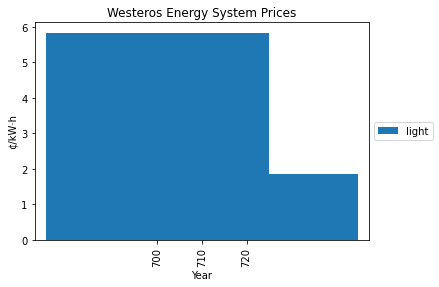

In [34]:
# Replace the technology filters with a commodity filter;
# show only "light" and not e.g. "electricity".
rep.set_filters(c=["light"])

# Create a price plot
rep.get("plot prices")

## Close the connection to the database

When working with local HSQLDB database instances, you cannot connect to one database from multipe Jupyter notebooks (or processes) at the same time.

If you want to easily switch between notebooks with connections to the same `ixmp` database, you need to close the connection in one notebook before initializing the platform using `ixmp.Platform()` in another notebook.

After having closed the database connection, you can reopen it using
```
mp.open_db()
```

In [35]:
mp.close_db()

## Congratulations! 

You have built and run your very first *MESSAGEix* model. Welcome to the community!

The next tutorials will introduce you to other features of the framework, including energy system constraints, emissions taxes, and other policy options.

Check us out on Github https://github.com/iiasa/message_ix  
and get in touch with us online https://groups.google.com/forum/message-ix ...